In [1]:
import sys
import numpy as np 
import pandas as pd 
sys.path.append('..')
import matplotlib.cm as cm
from src.datasets import HMDA 
import matplotlib.pyplot as plt
from src.proxies import gBisg, mlBisg
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [36]:
import matplotlib.pyplot as plt 
from src.datasets import HMDA
from src.proxies import gBisg, mlBisg

gbisg = gBisg()
hmda = HMDA("../data/hmda/state_MD-PA-NY-DE-VA.csv", 
            outcome=True, 
            include_geo=True, 
            geo="tract", 
            proxy=gbisg,
            races=["white", "black", "hispanic", "api"])

X_train, X_test, Y_train, Y_test, B_train, B_test = hmda.get_data(split=.9, return_bisg=True)


/Users/kaggrey/Documents/research/proxies/experiments/../src/proxies.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probs_new["other"] = probs.iloc[:,excl_indexes].sum(axis=1, min_count=1)


In [37]:
mlbisg = mlBisg(model="mr", proxy=None)
mlbisg.train(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
predicted = mlbisg.inference(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


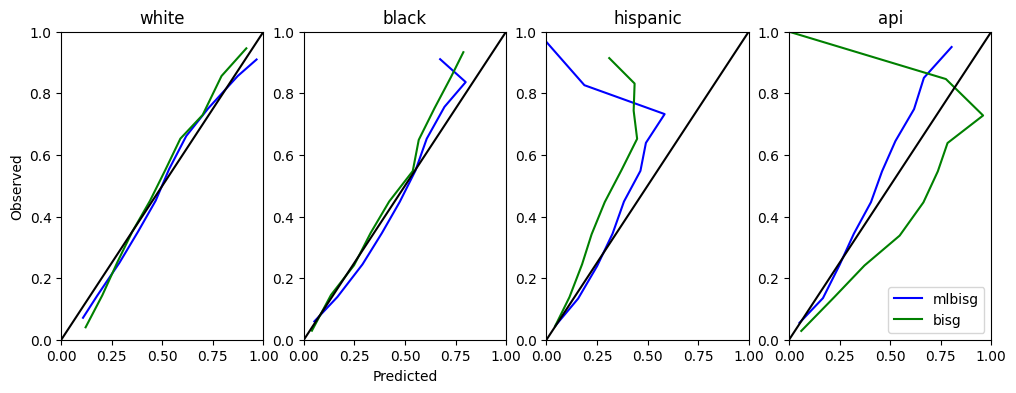

In [39]:
from sklearn.calibration import calibration_curve
n_bins = 10
race_ixes = [0,1, 2,3]
fig, axs = plt.subplots(1, len(race_ixes), figsize=(12,4))
plt.title("Race Prediction Calibration")


axs[0].set_ylabel("Observed")
axs[1].set_xlabel("Predicted")

for i, index in enumerate(race_ixes):
    race = B_test.columns[index]
    y_true = (Y_test == index)
    y_pred_mlbisg = predicted[:, index]
    prob_true, prob_pred_mlbisg = calibration_curve(y_true, y_pred_mlbisg, n_bins=n_bins)
    axs[i].plot(prob_true, prob_pred_mlbisg, color="blue", label="mlbisg")

    y_pred_bisg = B_test.iloc[:,index]
    prob_true, prob_pred_bisg = calibration_curve(y_true, y_pred_bisg, n_bins=n_bins)
    axs[i].plot(prob_true, prob_pred_bisg, color="green", label="bisg")

    y_eq_x = np.linspace(0,1,11)
    axs[i].plot(y_eq_x, y_eq_x, color="black")
    axs[i].set_title(race)
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)

plt.legend()



In [40]:
Y_test.value_counts(normalize=True, sort=False)

<lambda>
0           0.687955
1           0.140641
2           0.062248
3           0.082649
4           0.026507
Name: proportion, dtype: float64

In [41]:
predicted.mean(axis=0)

array([0.68705169, 0.14012638, 0.06243642, 0.08367874, 0.02670677])

In [42]:
B_test.mean(axis=0)

white       0.716740
black       0.146228
hispanic    0.073302
api         0.043801
other       0.019930
dtype: float64

Check Pr[g | f]

In [48]:
mask = X_test["Loan Originated"]
Y_test[mask].value_counts(normalize=True, sort=False)

<lambda>
0           0.723889
1           0.113269
2           0.055814
3           0.080377
4           0.026651
Name: proportion, dtype: float64

In [49]:
predicted[mask].mean(axis=0)

array([0.72257433, 0.11353399, 0.05552379, 0.08194178, 0.02642611])

In [50]:
B_test[mask].mean(axis=0)

white       0.734099
black       0.132512
hispanic    0.070144
api         0.043649
other       0.019596
dtype: float64

Check disparity

In [87]:
i = 2

In [88]:
#This is the right answer, Pr[f = 1 | A = i (var)]
X_test[Y_test.to_numpy() == i]["Loan Originated"].mean()

0.5394907418731502

In [89]:
#Our Guess
p = predicted[mask].mean(axis=0)
top = (p[i] * X_test["Loan Originated"].mean()) 
bottom = predicted.mean(axis=0)[i]
top/bottom

0.5350649604793258

In [90]:
#BISG Guess
p = B_test[mask].mean(axis=0)
top = (p[i] * X_test["Loan Originated"].mean()) 
bottom = predicted.mean(axis=0)[i]
top/bottom

/var/folders/6j/97pkxkbn20zdxwjg13tprrb00000gq/T/ipykernel_84577/2150325837.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top = (p[i] * X_test["Loan Originated"].mean())


0.6759524702957598